## Enabling Import of Custom Python Modules from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S12')
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/EVA4/S12')

In [3]:
from albumentations import *
from albumentations.pytorch import ToTensor
from download import download_image, segregate
import data_preprocess_Albumentation_module_1
import data_preprocess_Albumentation_module_s12
import dataset
import resnet, resnet_s12
import train_test_module_CrossEntropy
import gradcam_module
import lr_finder_module
import misclassified_module
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset


  pip install torch-lr-finder -v --global-option="amp"


CUDA Available? True
CUDA Available? True


In [4]:
from __future__ import print_function
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

### Using GPU instead of CPU

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA_LAUNCH_BLOCKING=1

CUDA Available? True


In [6]:
# download_image("http://cs231n.stanford.edu/tiny-imagenet-200.zip")
# segregate()

In [7]:
datadir = os.getcwd()+'/MergeData/Train'
trainset = torchvision.datasets.ImageFolder(root=datadir, transform=data_preprocess_Albumentation_module_s12.albumentation_train())
datadir = os.getcwd()+'/MergeData/Val'
testset = torchvision.datasets.ImageFolder(root=datadir, transform=data_preprocess_Albumentation_module_s12.albumentation_test())

Let us show some of the training images, for fun.



In [8]:
trainloader, testloader = data_preprocess_Albumentation_module_s12.get_train_test_loader(trainset, testset)

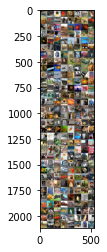

In [22]:
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [9]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = resnet_s12.ResNet18().to(device)
summary(net, input_size=(3, 64, 64))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1,

## LR Finder


Learning rate search finished. See the graph with {finder_name}.plot()


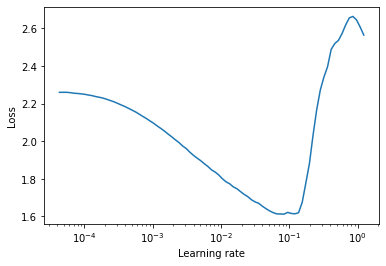

In [ ]:
from torch.optim.lr_scheduler import StepLR

net =  resnet_s12.ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0005)
lr_finder = lr_finder_module.LRFinder(net, optimizer, criterion)
lr_finder.range_test(trainloader, start_lr=1e-5, end_lr=2, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state


In [ ]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))

In [10]:
from torch.optim.lr_scheduler import StepLR, OneCycleLR 
from torch.optim.lr_scheduler import ReduceLROnPlateau

#net =  resnet_s12.ResNet18().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
#scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-5, factor=0.1, patience = 2)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr = 0.001, max_lr = 0.05, step_size_up=5, step_size_down=20, mode='triangular2')
# scheduler = OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(data.train_loader),
#                        epochs=epochs, div_factor=10, final_div_factor=10,
#                        pct_start=10/epochs)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_test_module_CrossEntropy.train(net, device, trainloader, optimizer, epoch)
    train_test_module_CrossEntropy.test(net, device, testloader)
    scheduler.step(train_test_module_CrossEntropy.test_losses[-1])

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.4294476509094238 Batch_id=9 Accuracy=27.71: 100%|██████████| 10/10 [00:20<00:00,  2.01s/it]
  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -3.9256, Accuracy: 115/690 (16.67%)

EPOCH: 1


Loss=1.3236945867538452 Batch_id=9 Accuracy=47.70: 100%|██████████| 10/10 [00:20<00:00,  2.00s/it]
  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -11.4446, Accuracy: 159/690 (23.04%)

EPOCH: 2


Loss=1.0616204738616943 Batch_id=9 Accuracy=57.40: 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]
  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -15.7909, Accuracy: 235/690 (34.06%)

EPOCH: 3


Loss=1.1050848960876465 Batch_id=9 Accuracy=61.56: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]
  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -19.4014, Accuracy: 275/690 (39.86%)

EPOCH: 4


  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -20.4161, Accuracy: 322/690 (46.67%)

EPOCH: 5


Loss=0.7475745677947998 Batch_id=9 Accuracy=71.26: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]
  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -21.0605, Accuracy: 398/690 (57.68%)

EPOCH: 6


Loss=0.7116793394088745 Batch_id=9 Accuracy=75.73: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]
  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -22.8317, Accuracy: 463/690 (67.10%)

EPOCH: 7


Loss=0.7159169912338257 Batch_id=9 Accuracy=77.08: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]
  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -23.0176, Accuracy: 412/690 (59.71%)

EPOCH: 8


Loss=0.7215489149093628 Batch_id=9 Accuracy=77.16: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]
  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -22.0342, Accuracy: 498/690 (72.17%)

EPOCH: 9


Loss=0.5836087465286255 Batch_id=9 Accuracy=81.08: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]
  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -25.1057, Accuracy: 425/690 (61.59%)

EPOCH: 10


Loss=0.40239065885543823 Batch_id=9 Accuracy=82.70: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]
  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -21.2610, Accuracy: 472/690 (68.41%)

EPOCH: 11


Loss=0.39757463335990906 Batch_id=9 Accuracy=87.37: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]
  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -21.5760, Accuracy: 491/690 (71.16%)

EPOCH: 12


Loss=0.48217880725860596 Batch_id=9 Accuracy=88.52: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]
  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -23.4294, Accuracy: 394/690 (57.10%)

EPOCH: 13


Loss=0.19036631286144257 Batch_id=9 Accuracy=92.16: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]
  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -22.9212, Accuracy: 540/690 (78.26%)

EPOCH: 14


Loss=0.15132801234722137 Batch_id=9 Accuracy=94.62: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]



Test set: Average loss: -22.7568, Accuracy: 527/690 (76.38%)



In [13]:
# Averaging the training accuracies across all batches to produce one value per epoch
n=10
train_acc = ([sum(train_test_module_CrossEntropy.train_acc[i:i+n])//n for i in range(0,len(train_test_module_CrossEntropy.train_acc),n)])

In [14]:
len(train_acc), len(train_test_module_CrossEntropy.test_acc) 

(15, 15)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

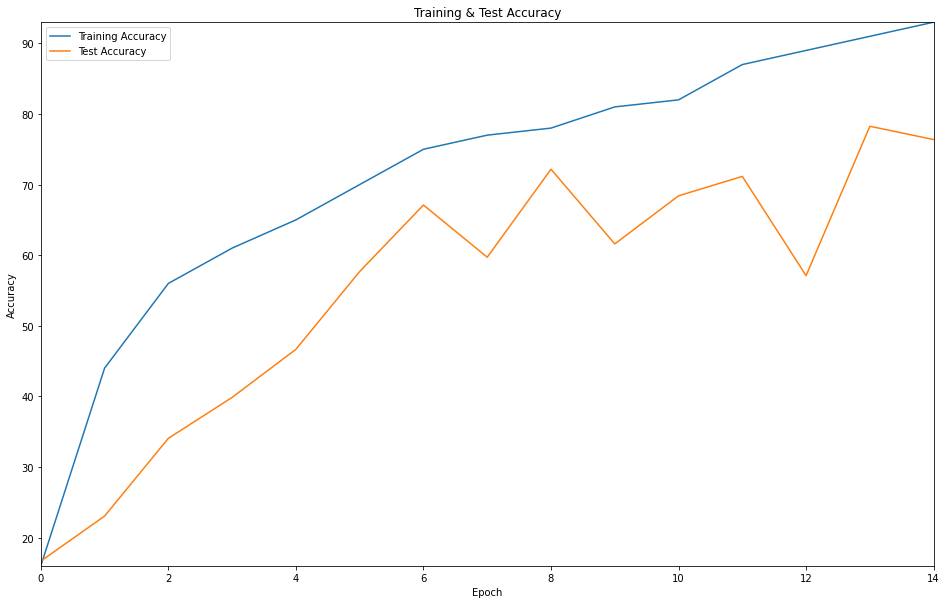

In [15]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(train_acc,label='Training Accuracy')
ax.plot(train_test_module_CrossEntropy.test_acc,label='Test Accuracy')
plt.autoscale(enable = True, axis = 'both',tight = 'true')
plt.title("Training & Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

from google.colab import files
plt.savefig("Training & Test Accuracy.png")
files.download("Training & Test Accuracy.png")